In [1]:
import pandas as pd
import re
import datetime as dt
import pandas as pd
import numpy as np
import os
import datetime
import re
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_colwidth',30)
pd.set_option('display.width', 1800)

merge = pd.read_csv("data/merged_data.csv")

In [2]:
"""
Helper functions
"""

def plot_checkNaNs(df_train2):
    (df_train2.isna().sum()/len(df_train2)*100).plot(kind='bar', figsize=(40,4), color='lightblue') 
    plt.title('Percentage of Variable\'s Values as NaNs',
              size=16)
    plt.ylabel('%-tage NaNs')
    plt.show()
    
def plot_relationship_w_response(merge, x,n):
    ax = fig.add_subplot(2,2,n)
    ax.set_xlabel(x)
    ax.set_ylabel("Frequency") 
    g = sns.FacetGrid(merge, hue='next_game_hit_vs_fp', palette={1: "g", 0: "r"})
    g.map(sns.distplot, x, kde=False, bins=15, ax=ax)
    ax.legend(title='hit result')
    plt.close(2)
    
def perform_k_stratsplits(df, strat_col, k=1, randomstate = 42):
    """Perform stratified sampling according to Interval category. The currencies are going to be scaled."""
    # we use StratifiedShuffleSplit library in order to give us a good stratified shuffle. 
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=randomstate)
    for train_index, test_index in split.split(df, df[strat_col]):
        final_test_set = df.loc[test_index].reset_index(drop = True)
        train_set = df.loc[train_index].reset_index(drop=True)
#         final_test_set.drop(["Interval"], axis=1, inplace=True)

    ## IMPORTANT ---- final_test_set or final hold out set contains the last test set that we are setting aside.

    """Create k different train test splits with the 80 percent remaining in our dataset"""
    # train split at index i matches with test split at index i
    train_splits = []
    test_splits = []
    # we use StratifiedShuffleSplit library in order to give us a good stratified shuffle. 
    split = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(train_set, train_set[strat_col]):
        strat_train_set = train_set.loc[train_index]
        strat_test_set = train_set.loc[test_index]
        train_splits.append(strat_train_set)
        test_splits.append(strat_test_set)
        df_strat = pd.DataFrame()
        df_strat["overall"] = train_set[strat_col].value_counts() / len(train_set)
        df_strat["stratified_test"] = strat_test_set[strat_col].value_counts() / len(strat_test_set)
        df_strat["stratified_train"] = strat_train_set[strat_col].value_counts() / len(strat_train_set)
#         print(df_strat.head())
#         df_strat = pd.DataFrame()
#         df_strat["overall"] = train_set["Interval"].value_counts() / len(train_set)
#         df_strat["stratified_test"] = strat_test_set["Interval"].value_counts() / len(strat_test_set)
#         df_strat["stratified_train"] = strat_train_set["Interval"].value_counts() / len(strat_train_set)
        print(df_strat.head())
#         for set in (strat_train_set, strat_test_set):
#             set.drop(["Currency"], axis=1, inplace=True)
        
    return train_splits, test_splits, final_test_set

def generate_scores(clf, x, y, t = "regular"):
    
    results_df = pd.DataFrame()
    results_df["Y_actual"] =  y
    if (t == "deep"):
        results_df["X_predicted"] = [j[0] for j in clf.predict(x)]
    else:
        results_df["X_predicted"] = [j[1] for j in clf.predict_proba(x)]
    
    if (t == "deep"):
        cm = plot_confusion_matrix(y, clf.predict_classes(x))
        plt.show()
        ps = precision_score(y, clf.predict_classes(x))
        print("\tprecision", ps)
        rs = recall_score(y, clf.predict_classes(x))
        print("\trecall", rs)
        f1 = f1_score(y, clf.predict_classes(x))
        print("\tf1", f1)
        print("")
    else:
        cm = plot_confusion_matrix(y, clf.predict(x))
        plt.show()
        ps = precision_score(y, clf.predict(x))
        print("\tprecision", ps)
        rs = recall_score(y, clf.predict(x))
        print("\trecall", rs)
        f1 = f1_score(y, clf.predict(x))
        print("\tf1", f1)
        print("")
    
    return [ps, rs, f1, results_df]

def plot_confusion_matrix(y,y_):
    cmap=plt.cm.Blues
    cm = metrics.confusion_matrix(y, y_)
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 3)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    classes = ["non-hit", "hit"]
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 3.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color= "black")
    return ax

def get_top_x_scores(clf, x, y, top, t = "regular"):
    results_df = pd.DataFrame()
    results_df["Y_actual"] =  y
    if (t == "deep"):
        results_df["X_predicted"] = [j[0] for j in clf.predict(x)]
    else:
        results_df["X_predicted"] = [j[1] for j in clf.predict_proba(x)]
    results_df = results_df.sort_values(by = "X_predicted", ascending = False).reset_index(drop = True)
    
    predicted = np.array([1 if k>=.5 else 0 for k in results_df["X_predicted"]])[:top]
    true = results_df["Y_actual"].values[:top]
    cm = plot_confusion_matrix(true, predicted)
#     print(cm)
    plt.show()
    ps = precision_score(true, predicted)
    print("\tprecision", ps)
    rs = recall_score(true, predicted)
    print("\trecall", rs)
    f1 = f1_score(true, predicted)
    print("\tf1", f1)
    print("")
    
    return [ps, rs, f1, results_df]

In [3]:
%run preprocessing.py

"""
Preprocess the dataset to clean out the null values and to 
"""

df = merge.copy()
df = df[df["PARK NAME"].notnull() & df["Wind Direction"].notnull()].reset_index(drop = True)
prep = Preprocess(df,add_player_encoder = False)
prep.encode_classes()
pass

In [4]:
df = prep.dataframe
df = df.drop(columns = ["Unnamed: 0"])
df = df[df["Date_x"].notnull()]
df["Date"] = df['Date_x'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
df["Month"] = df["Date"].apply(lambda x: x.month)
df["Year"] = df["Date"].apply(lambda x: x.year)
df = df.sort_values(by = "Date")

## split the set into training, validation and testing

In [5]:
predictor_vars = ["PA","BA","pHitsByZone3",
                  "hitter_R%", "BIP", "BABIP", "LA_median", "Weather (Degrees)", "Wind (MPH)",
                  "Area_stand", "Altitude", "H", "RUNS", "pitches_per_appearance_avg", "strikeout_percentage", "hip_last_three",
                  "ground_ball_percentage", "Strikes_Swinging"]
# predictor_vars = cols
# target = "next_game_hit_vs_fp"
target = "next_game_HIT"
x = df[["Month", target] + predictor_vars]
X = x.dropna().reset_index(drop=True)

print(set(X.columns) - set(predictor_vars))

eighty = X[:int(len(X)*0.8)].reset_index(drop=True)

valid = int(0.8*len(eighty))
pre_train = eighty[:valid].reset_index(drop=True)
train = balance_hits(pre_train, target = "next_game_HIT")

Y_train = train[target].reset_index(drop=True)
X_train = train[predictor_vars].reset_index(drop=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)


Y_validation = eighty[valid:][target].reset_index(drop=True)
X_validation = eighty[valid:][predictor_vars].reset_index(drop=True)
X_validation = scaler.transform(X_validation)


test = X[int(len(X)*0.8):]
Y_test = test[target].reset_index(drop=True)
X_test = test[predictor_vars].reset_index(drop=True)
X_test = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
log_reg = LogisticRegression(solver = 'sag')
clf = log_reg.fit(X_train, Y_train)

{'next_game_HIT', 'Month'}


c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


### Logistic Regression General Scores


Validation Set:


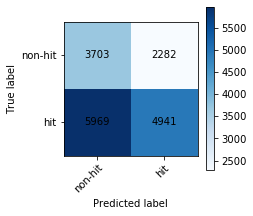

	precision 0.68406479302229
	recall 0.4528872593950504
	f1 0.5449732531848013


Test set:


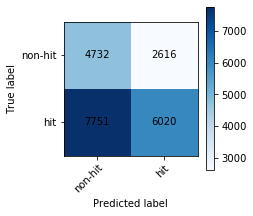

	precision 0.6970819823992589
	recall 0.4371505337303028
	f1 0.5373320837238363



In [6]:
# print("\nTraining Set:")
# lr_train = generate_scores(clf, X_train, Y_train)
print("\nValidation Set:")
lr_val = generate_scores(clf, X_validation, Y_validation)
print("\nTest set:")
lr_test = generate_scores(clf, X_test, Y_test)
pass

### Logistic Regression top K (150) Precision

Training Set:


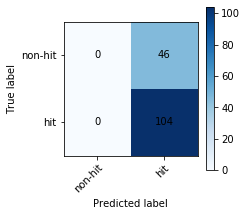

	precision 0.6933333333333334
	recall 1.0
	f1 0.8188976377952756

Validation Set:


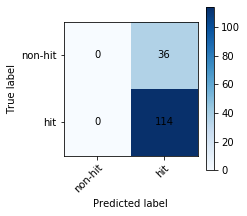

	precision 0.76
	recall 1.0
	f1 0.8636363636363636

Test Set:


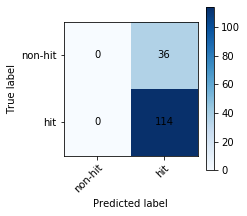

	precision 0.76
	recall 1.0
	f1 0.8636363636363636



In [7]:
k = 150
print("Training Set:")
a =get_top_x_scores(clf, X_train, Y_train, k)
print("Validation Set:")
z =get_top_x_scores(clf, X_validation, Y_validation, k)
print("Test Set:")
j = get_top_x_scores(clf, X_test, Y_test, k)

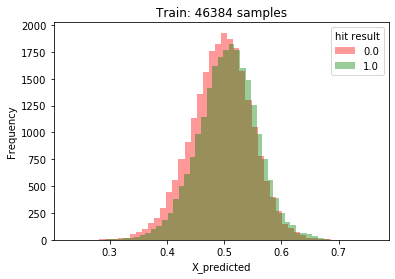

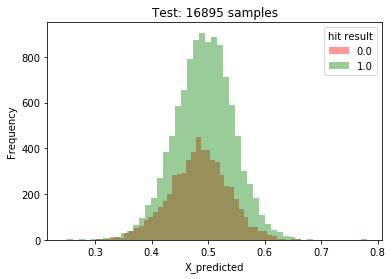

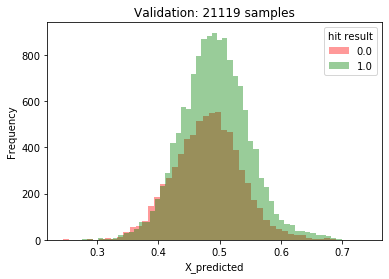

In [8]:
dic = {0: "Train", 1: "Test", 2: "Validation"}
for i, x in enumerate([a, z, j]):
    fig, ax = plt.subplots()
    ax.set_xlabel("Probability")
    ax.set_ylabel("Frequency") 
    g = sns.FacetGrid(x[3], hue='Y_actual', palette={1: "g", 0: "r"})
    g.map(sns.distplot, "X_predicted", kde=False, bins=50, ax=ax)
    
    ax.legend(title='hit result')
    plt.close(2)
    plt.title(dic[i] + ": " + str(len(x[3])) + " samples")
    plt.show()

Text(0.5, 1.0, 'Feature Importances for Logistic Regression Model')

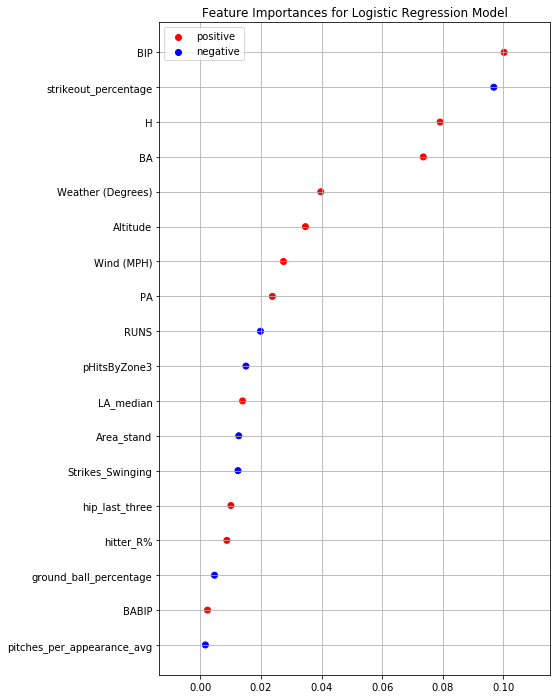

In [9]:
importances = pd.DataFrame()
importances["name"] = predictor_vars
importances["value"] = [x for x in clf.coef_[0]]
importances["color"] = ["blue" if x < 0 else "red" for x in importances["value"]]
importances["value"] = [abs(x) for x in importances['value']]
importances = importances.sort_values(by = "value", ascending  = True)


plt.figure(figsize=(7,12))
plt.scatter(x = [], y = [],color = "red")
plt.scatter(x = [], y = [],color = "blue")
plt.scatter(x = importances["value"], y = importances["name"], color = importances["color"])

plt.grid()
plt.legend(('positive', 'negative'))
plt.title("Feature Importances for Logistic Regression Model")

# Deep learning model

In [10]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt; plt.rcdefaults()
import sys
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime

X_train.shape
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
Y_validation = Y_validation.to_numpy()

In [11]:
start = datetime.now()
checkpointer = ModelCheckpoint(filepath='saved_models/three_layers4.hdf5',
                               verbose=1, save_best_only = True)
dimen = X_train.shape[1]
optimizer = tf.keras.optimizers.Adam(lr=0.005)
model = models.Sequential()
# number of columns is input dimension
model.add(layers.Dense(dimen, input_dim = dimen))
# model.add(layers.Dense(dimen, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ["accuracy", tf.keras.metrics.Precision(name = "prec")])
# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"])

model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size = 64, epochs =15, callbacks = [checkpointer], verbose = 1)
# results = model.evaluate(X_test, Y_test, batch_size=512, verbose=0)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 46384 samples, validate on 21119 samples
Epoch 1/15
45952/46384 [============================>.] - ETA: 0s - loss: 0.6955 - accuracy: 0.5294 - prec: 0.5291
Epoch 00001: val_loss improved from inf to 0.69353, saving model to saved_models/three_layers4.hdf5
46384/46384 [==============================] - 4s 87us/sample - loss: 0.6954 - accuracy: 0.5293 - prec: 0.5289 - val_loss: 0.6935 - val_accuracy: 0.5173 - val_prec: 0.6864
Epoch 2/15
45888/46384 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.5370 - prec: 0.5367
Epoch 00002: val_loss did not improve from 0.69353
46384/46384 [==============================] - 3s 54us/sample - loss: 0.6901 - accuracy: 0.5373 - prec: 0.5366 - val_loss: 0.7054 - val_accuracy: 0.4594 - val_prec: 0.6965
Epoch 3/15
45184/46384 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5374 - prec: 0.5369
Epoch 00003: val_loss did not improve from 0.69353
46384/46384 [==============================] - 3s 55us/samp

## Deep Learning General scores

Training Set:


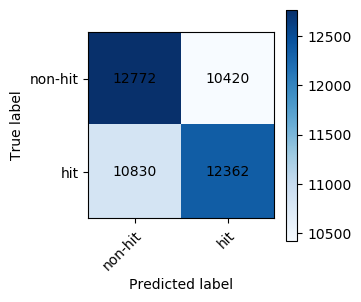

	precision 0.5426213677464665
	recall 0.5330286305622628
	f1 0.5377822247357202

Validation Set:


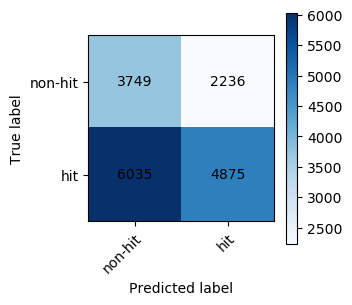

	precision 0.6855575868372943
	recall 0.44683776351970667
	f1 0.5410354586315964

Test set:


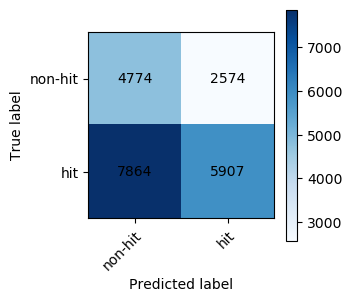

	precision 0.6964980544747081
	recall 0.42894488417689347
	f1 0.5309185691173827



In [12]:
# model = load_model('saved_models/two_layers.hdf5')
print("Training Set:")
generate_scores(model, X_train, Y_train, "deep")

print("Validation Set:")
generate_scores(model, X_validation, Y_validation, "deep")

print("Test set:")
generate_scores(model, X_test, Y_test, "deep")
pass

In [13]:
def get_balance(Y):
    num_ones =sum(Y)
    num_zeros = len(Y) - sum(Y)
    print(num_ones, num_zeros)

get_balance(Y_train)
get_balance(Y_test)
get_balance(Y_validation)

23192.0 23192.0
13771.0 7348.0
10910.0 5985.0


## Deep Learning top K (150) Precision

Training Set:


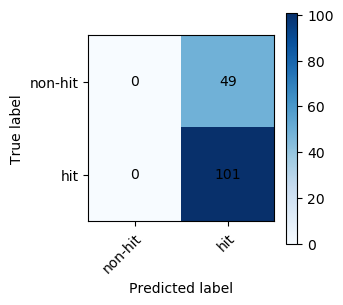

	precision 0.6733333333333333
	recall 1.0
	f1 0.8047808764940239

Validation Set:


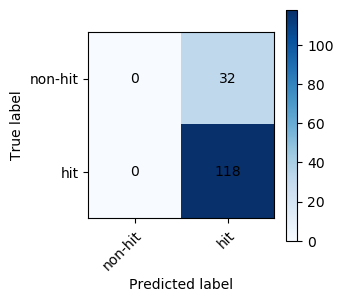

	precision 0.7866666666666666
	recall 1.0
	f1 0.8805970149253731

Test Set:


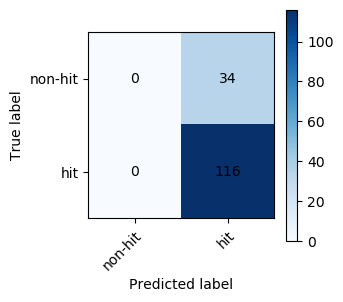

	precision 0.7733333333333333
	recall 1.0
	f1 0.8721804511278195



In [14]:
k = 150
print("Training Set:")
a =get_top_x_scores(model, X_train, Y_train, k, "deep")

print("Validation Set:")
z =get_top_x_scores(model, X_validation, Y_validation, k, "deep")

print("Test Set:")
j = get_top_x_scores(model, X_test, Y_test, k, "deep")
pass


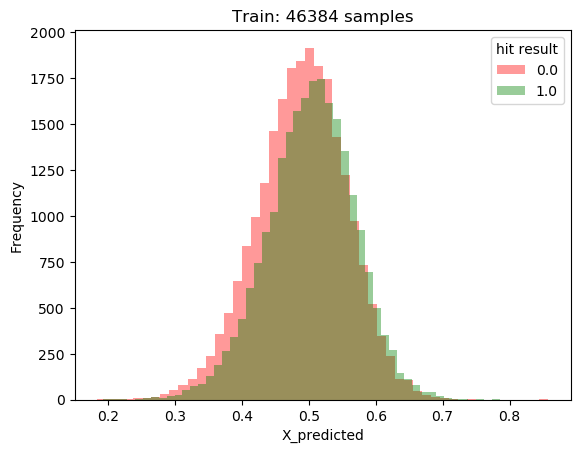

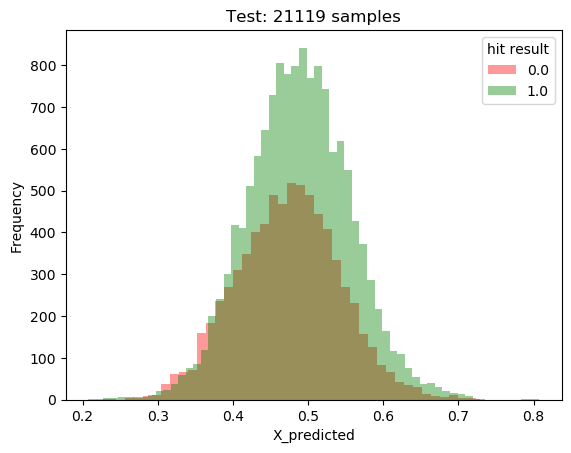

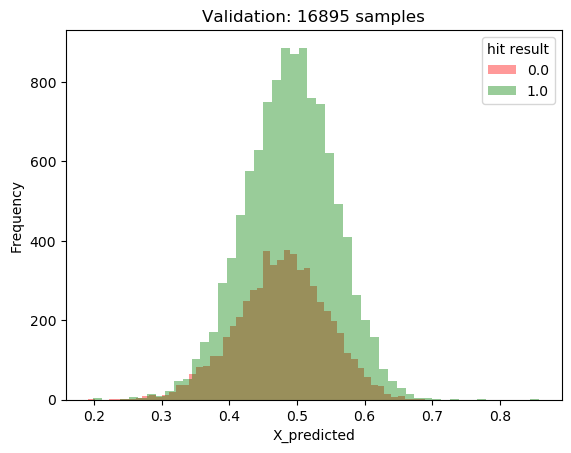

In [15]:
dic = {0: "Train", 1: "Test", 2: "Validation"}
for i, x in enumerate([a, j, z]):
    fig, ax = plt.subplots()
    ax.set_xlabel("Probability")
    ax.set_ylabel("Frequency") 
    g = sns.FacetGrid(x[3], hue='Y_actual', palette={1: "g", 0: "r"})
    g.map(sns.distplot, "X_predicted", kde=False, bins=50, ax=ax)
    
    ax.legend(title='hit result')
    plt.close(2)
    plt.title(dic[i] + ": " + str(len(x[3])) + " samples")
    plt.show()

## Breakdown

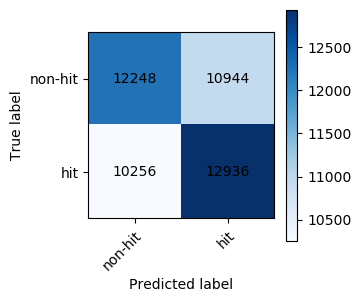

	precision 0.5417085427135678
	recall 0.5577785443256296
	f1 0.5496261046906866



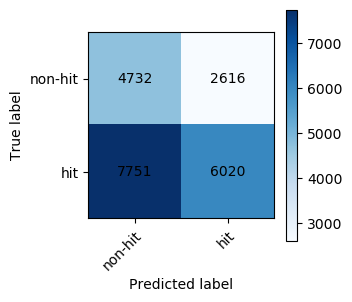

	precision 0.6970819823992589
	recall 0.4371505337303028
	f1 0.5373320837238363



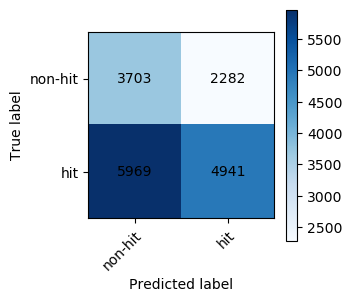

	precision 0.68406479302229
	recall 0.4528872593950504
	f1 0.5449732531848013



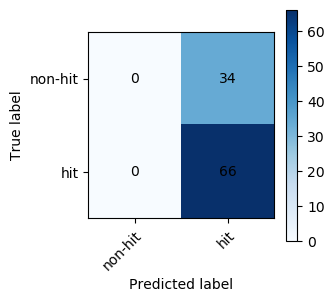

	precision 0.66
	recall 1.0
	f1 0.7951807228915663



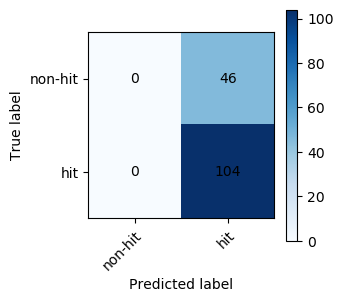

	precision 0.6933333333333334
	recall 1.0
	f1 0.8188976377952756



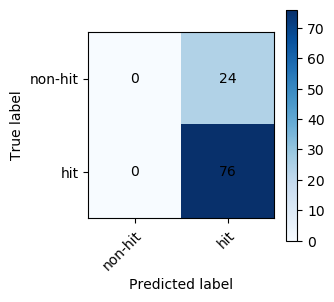

	precision 0.76
	recall 1.0
	f1 0.8636363636363636



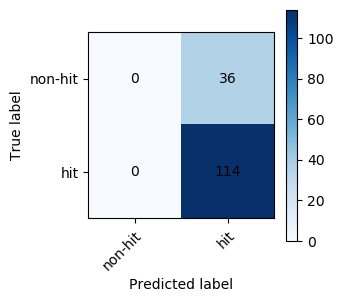

	precision 0.76
	recall 1.0
	f1 0.8636363636363636



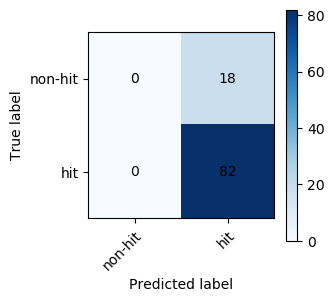

	precision 0.82
	recall 1.0
	f1 0.9010989010989011



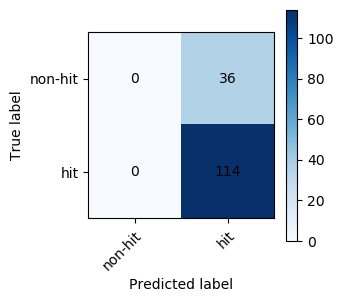

	precision 0.76
	recall 1.0
	f1 0.8636363636363636



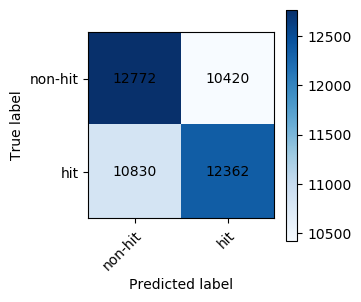

	precision 0.5426213677464665
	recall 0.5330286305622628
	f1 0.5377822247357202



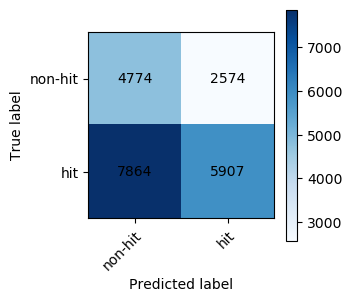

	precision 0.6964980544747081
	recall 0.42894488417689347
	f1 0.5309185691173827



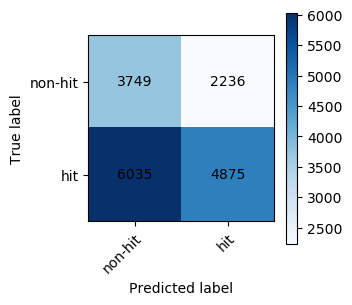

	precision 0.6855575868372943
	recall 0.44683776351970667
	f1 0.5410354586315964



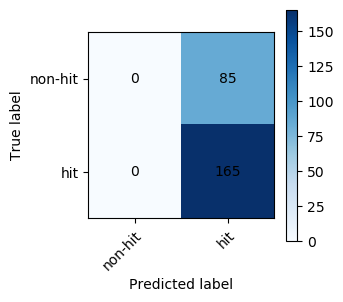

	precision 0.66
	recall 1.0
	f1 0.7951807228915663



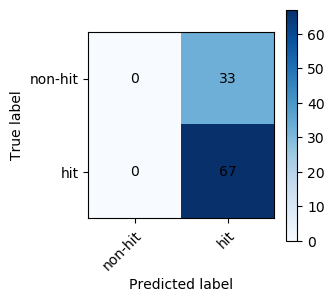

	precision 0.67
	recall 1.0
	f1 0.8023952095808384



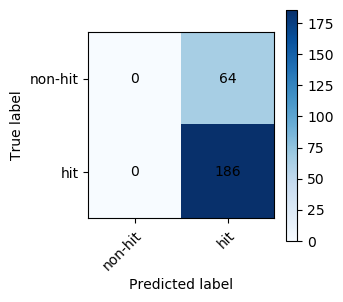

	precision 0.744
	recall 1.0
	f1 0.8532110091743119



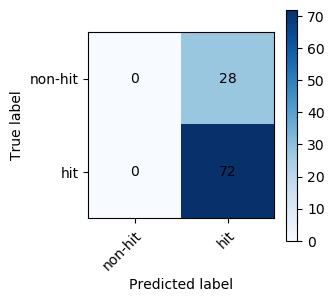

	precision 0.72
	recall 1.0
	f1 0.8372093023255813



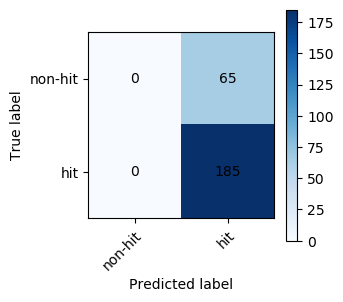

	precision 0.74
	recall 1.0
	f1 0.8505747126436781



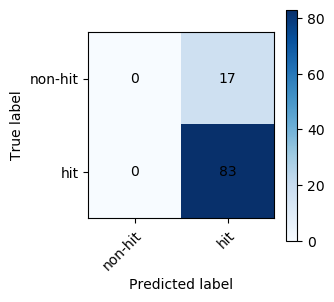

	precision 0.83
	recall 1.0
	f1 0.9071038251366119



In [16]:
results = pd.DataFrame(columns = ["Model", "Set", "Num. Samples", "Precision", "Recall", "F1", "Top 250 Precision", "Top 100 Precision"])

logistic_train = ["Logistic Regression", "Train", len(Y_train) ]
logistic_test = ["Logistic Regression", "Test", len(Y_test) ]
logistic_validation = ["Logistic Regression", "Validation", len(Y_validation)]

tr = generate_scores(clf, X_train, Y_train)[:-1]
te = generate_scores(clf, X_test, Y_test)[:-1]
va = generate_scores(clf, X_validation, Y_validation)[:-1]
tr_x = [get_top_x_scores(clf, X_train, Y_train, 100)[0]] + [get_top_x_scores(clf, X_train, Y_train, 150)[0]]
te_x = [get_top_x_scores(clf, X_test, Y_test, 100)[0]] + [get_top_x_scores(clf, X_test, Y_test, 150)[0]]
va_x = [get_top_x_scores(clf, X_validation, Y_validation, 100)[0]] + [get_top_x_scores(clf, X_validation, Y_validation, 150)[0]]

logistic_train = logistic_train + list(tr) + list(tr_x)
logistic_test = logistic_test + list(te) + list(te_x) 
logistic_validation = logistic_validation + list(va) + list(va_x)    

MLP_train = ["Multilayer Perceptron", "Train", len(Y_train) ]
MLP_test = ["Multilayer Perceptron", "Test", len(Y_test) ]
MLP_val = ["Multilayer Perceptron", "Validation", len(Y_validation)]

tr = generate_scores(model, X_train, Y_train, "deep")[:-1]
te = generate_scores(model, X_test, Y_test, "deep")[:-1]
va = generate_scores(model, X_validation, Y_validation, "deep")[:-1]
tr_x = [get_top_x_scores(model, X_train, Y_train, 250, "deep")[0]] + [get_top_x_scores(model, X_train, Y_train, 100, "deep")[0]]
te_x = [get_top_x_scores(model, X_test, Y_test, 250, "deep")[0]] + [get_top_x_scores(model, X_test, Y_test, 100, "deep")[0]]
va_x = [get_top_x_scores(model, X_validation, Y_validation, 250, "deep")[0]] + [get_top_x_scores(model, X_validation, Y_validation, 100, "deep")[0]]

MLP_train = MLP_train + list(tr) + list(tr_x)
MLP_test = MLP_test + list(te) + list(te_x)
MLP_val = MLP_val + list(va) + list(va_x)

rows = [logistic_train, logistic_test, logistic_validation, MLP_train, MLP_test, MLP_val]
for j,r in enumerate(rows):
    results.loc[j] = r

In [17]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns[2:])

## Summary of results

In [18]:
results.style.apply(highlight_max, subset=pd.IndexSlice[:, ["Num. Samples", "Precision", "Recall", "F1", "Top 250 Precision", "Top 100 Precision"]])

,Model,Set,Num. Samples,Precision,Recall,F1,Top 250 Precision,Top 100 Precision
0,Logistic Regression,Train,46384,0.541709,0.557779,0.549626,0.66,0.693333
1,Logistic Regression,Test,21119,0.697082,0.437151,0.537332,0.76,0.76
2,Logistic Regression,Validation,16895,0.684065,0.452887,0.544973,0.82,0.76
3,Multilayer Perceptron,Train,46384,0.542621,0.533029,0.537782,0.66,0.67
4,Multilayer Perceptron,Test,21119,0.696498,0.428945,0.530919,0.744,0.72
5,Multilayer Perceptron,Validation,16895,0.685558,0.446838,0.541035,0.74,0.83


In [225]:
results.style.apply(highlight_max, subset=pd.IndexSlice[:, ["Num. Samples", "Precision", "Recall", "F1", "Top 250 Precision", "Top 100 Precision"]])

,Model,Set,Num. Samples,Precision,Recall,F1,Top 250 Precision,Top 100 Precision
0,Logistic Regression,Train,43968,0.541261,0.558224,0.549611,0.71,0.68
1,Logistic Regression,Test,25069,0.670766,0.674916,0.672834,0.83,0.78
2,Logistic Regression,Validation,16105,0.699048,0.483304,0.571492,0.8,0.78
3,Multilayer Perceptron,Train,43968,0.54398,0.488082,0.514517,0.672,0.71
4,Multilayer Perceptron,Test,25069,0.675867,0.590676,0.630407,0.776,0.77
5,Multilayer Perceptron,Validation,16105,0.700152,0.434014,0.535857,0.764,0.77


In [208]:
# pd.concat([results.iloc[:,:2],to_highlight.style.apply(highlight_max)], axis = 0)
results.style.apply(highlight_max, subset=pd.IndexSlice[:, ["Num. Samples", "Precision", "Recall", "F1", "Top 250 Precision", "Top 100 Precision"]])

,Model,Set,Num. Samples,Precision,Recall,F1,Top 250 Precision,Top 100 Precision
0,Logistic Regression,Train,43982,0.541798,0.555545,0.548586,0.65,0.666667
1,Logistic Regression,Test,25069,0.673548,0.611674,0.641121,0.79,0.78
2,Logistic Regression,Validation,16109,0.698498,0.476679,0.566654,0.79,0.8
3,Multilayer Perceptron,Train,43982,0.541817,0.552362,0.547039,0.624,0.59
4,Multilayer Perceptron,Test,25069,0.676334,0.590239,0.63036,0.748,0.78
5,Multilayer Perceptron,Validation,16109,0.701332,0.485142,0.573541,0.764,0.81


{'next_game_HIT', 'Month'}
1.0    21991
0.0    21991
Name: next_game_HIT, dtype: int64


c:\users\elong\anaconda3\envs\instrument_ai\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\elong\OneDrive\Desktop\baseball_data\baseball_scraper\baseball_scraper\models.py:224: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X_train = scaler.transform(X_train)
C:\Users\elong\OneDrive\Desktop\baseball_data\baseball_scraper\baseball_scraper\models.py:229: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X_validation = scaler.transform(X_validation)
C:\Users\elong\OneDrive\Desktop\baseball_data\baseball_scraper\baseball_scraper\models.py:235: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X_test = scaler.transform(X_test)
c:\users\elong\anaconda3\env

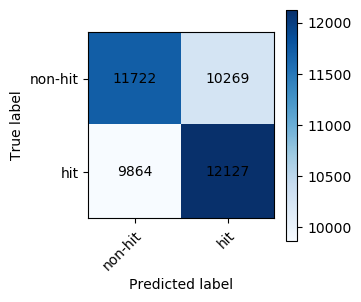

	precision 0.5414806215395607
	recall 0.551452867081988
	f1 0.5464212494649334



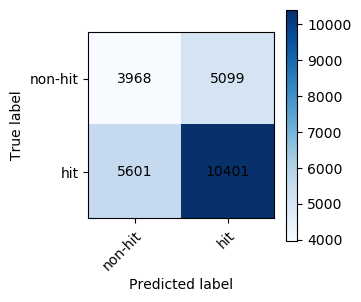

	precision 0.6710322580645162
	recall 0.649981252343457
	f1 0.6603390260935814



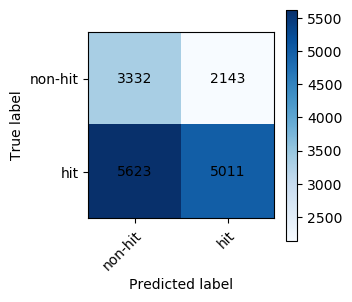

	precision 0.7004473022085547
	recall 0.47122437464735756
	f1 0.5634135372161008



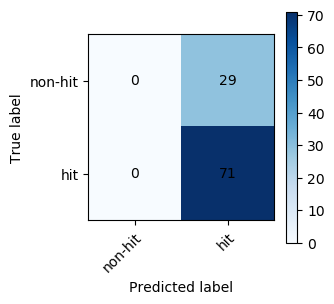

	precision 0.71
	recall 1.0
	f1 0.8304093567251462



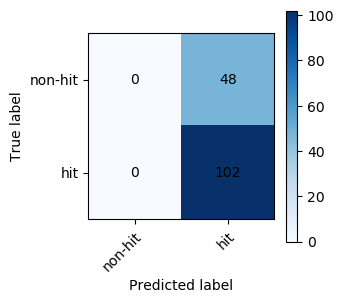

	precision 0.68
	recall 1.0
	f1 0.8095238095238095



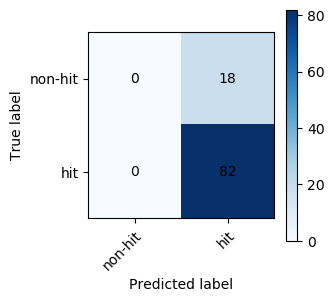

	precision 0.82
	recall 1.0
	f1 0.9010989010989011



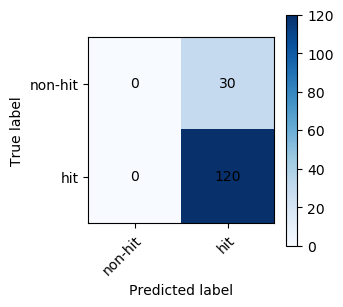

	precision 0.8
	recall 1.0
	f1 0.888888888888889



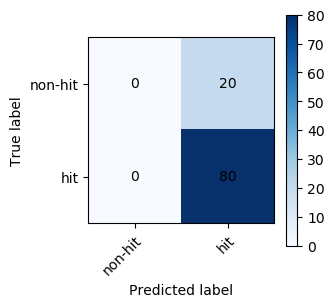

	precision 0.8
	recall 1.0
	f1 0.888888888888889



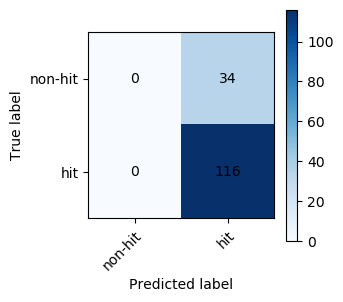

	precision 0.7733333333333333
	recall 1.0
	f1 0.8721804511278195



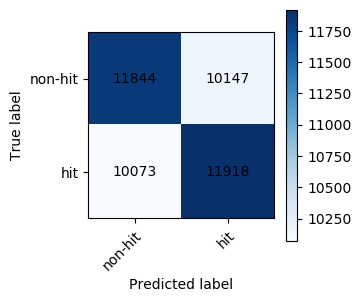

	precision 0.5401314298663041
	recall 0.541948979127825
	f1 0.5410386780461232



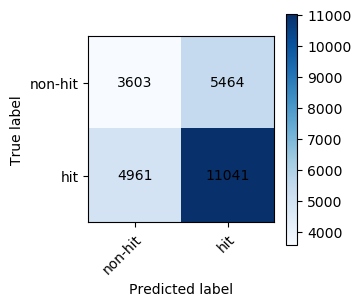

	precision 0.6689488033929112
	recall 0.689976252968379
	f1 0.6792998431107146



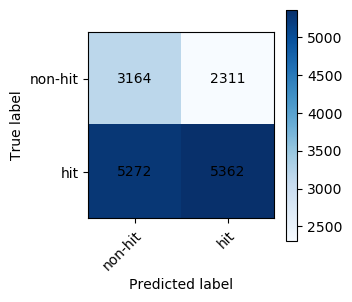

	precision 0.6988140231982275
	recall 0.5042317096106828
	f1 0.5857868574862074



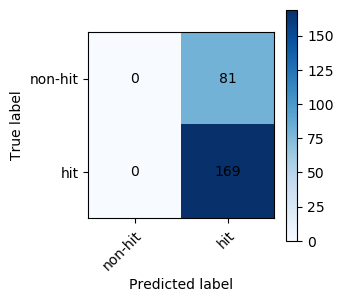

	precision 0.676
	recall 1.0
	f1 0.8066825775656324



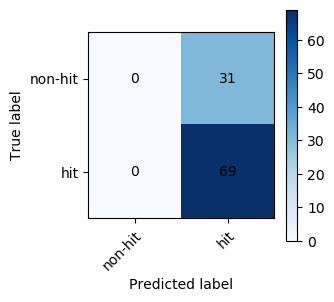

	precision 0.69
	recall 1.0
	f1 0.8165680473372781



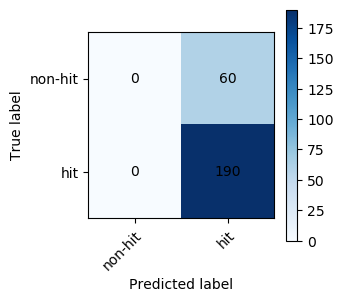

	precision 0.76
	recall 1.0
	f1 0.8636363636363636



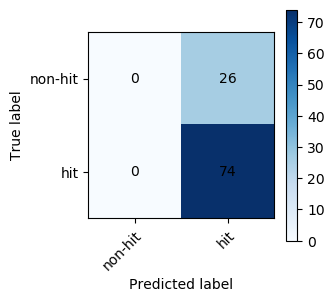

	precision 0.74
	recall 1.0
	f1 0.8505747126436781



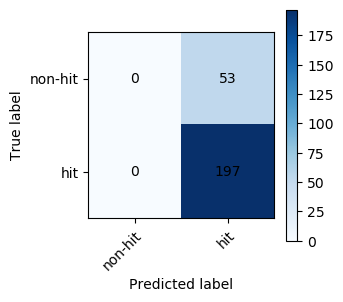

	precision 0.788
	recall 1.0
	f1 0.8814317673378076



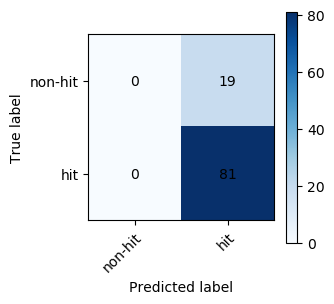

	precision 0.81
	recall 1.0
	f1 0.8950276243093923

                   Model         Set Num. Samples  Precision    Recall        F1  Top 250 Precision  Top 100 Precision
0    Logistic Regression       Train        43982   0.541481  0.551453  0.546421              0.710           0.680000
1    Logistic Regression        Test        25069   0.671032  0.649981  0.660339              0.820           0.800000
2    Logistic Regression  Validation        16109   0.700447  0.471224  0.563414              0.800           0.773333
3  Multilayer Perceptron       Train        43982   0.540131  0.541949  0.541039              0.676           0.690000
4  Multilayer Perceptron        Test        25069   0.668949  0.689976  0.679300              0.760           0.740000
5  Multilayer Perceptron  Validation        16109   0.698814  0.504232  0.585787              0.788           0.810000


In [209]:
%run models.py